# Análise da Distribuição dos Pesos de Dimantes

**Autor** - Leonardo Fernandes Moutinho Rocha

Uma empresa de mineração de diamantes pretende estimar o peso total em quilates
extraído com base nas condições de campo. Para isso, é necessário encontrar uma
distribuição estatística que se ajuste bem aos dados e, com base nela, serão
gerados valores aleatórios para estimar probabilidades de peso total extraído
com base no número diário de diamantes.
  1. Utilizando o data-set fornecido, de dados de diamantes, encontre uma curva
  que bem se adequa à variável carat (peso em quilates). Para isso, proponha
  pelo menos três distribuições que representam de forma adequada os dados e
  utilize um critério de seleção de modelos para determinar a melhor
  distribuição.
  2. Com base na distribuição escolhida, gere um histograma que representa a
  distribuição do peso total extraído pela empresa caso sejam extraídas 100
  unidades de diamantes por dia. Qual a distribuição dessa variável peso total?
  3. Explique o passo a passo e discorra sobre os resultados.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pomegranate import LogNormalDistribution, GeneralMixtureModel
from scipy import stats

## Carregando os dados

Para carregar os dados selecionamos apenas a coluna de interesse **carat**.
Em seguida a compactamos para um `pd.Series` ao invés de trabalhar com
um `pd.DataFrame` de apenas uma coluna. Como resultado obtemos uma série de
dados numérica (`float`) sem registros faltantes.

In [2]:
# os dados da série de carat
filepath = "Teste Ciência de Dados diamonds.csv"
carat = pd.read_csv(filepath, usecols=["carat"]).squeeze("columns")
carat.head()

0    0.23
1    0.21
2    0.23
3    0.29
4    0.31
Name: carat, dtype: float64

In [3]:
carat.info()

<class 'pandas.core.series.Series'>
RangeIndex: 53940 entries, 0 to 53939
Series name: carat
Non-Null Count  Dtype  
--------------  -----  
53940 non-null  float64
dtypes: float64(1)
memory usage: 421.5 KB


## Análise preliminar da distribuição dos dados

Em uma análise prelininar das estatísticas descritvas da distribuição de
`carat`, conseguimos identificar indícios de que a distribuição seja
assimétrica. Mais especificamente com uma **assimetria para a direita**,
uma vez que a média (0.80) é maior que a mediana (0.70). O intervalo máximo
dessa distribuição também não é muito grande. O menor valor é 0.2 enquanto o 
maior 5.01. Reforçando a evidência de assimetria à direita, apesar do máximo
ser 5.01, como dito anteriormente, 75% dos valores estão a baixo de 1.04.

In [4]:
carat.describe().round(2)

count    53940.00
mean         0.80
std          0.47
min          0.20
25%          0.40
50%          0.70
75%          1.04
max          5.01
Name: carat, dtype: float64

In [23]:
def plot_distr(x: pd.Series) -> None:
    """"Função que gera os gráficos """
    # Criando a figura com três gráficos
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    # primeiro gráfico sendo um boxplot
    ax1.set_title("Boxplot")
    sns.boxplot(x=x, ax=ax1)
    # segundo gráfico um histograma
    ax2.set_title("Histograma")
    x.hist(bins=100, density=True, ax=ax2)
    # terceiro gráfico a função de distribuição acumulada empírica
    x.value_counts(normalize=True).sort_index().cumsum().plot(ax=ax3)
    ax3.set_title("Distribuição Acumulada Empírica")
    ax3.set_xlabel(x.name)
    # adicionando título à figura
    fig.suptitle(f"Análise da distribuição da variável {x.name}", fontsize=20)
    plt.show()

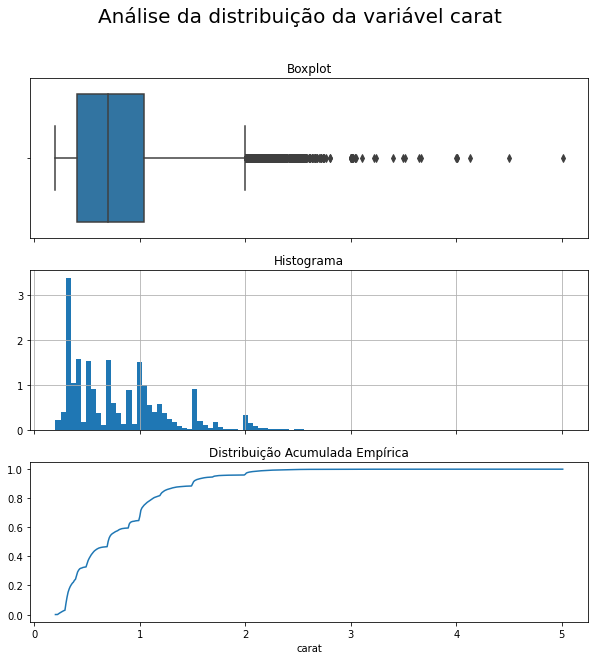

In [24]:
plot_distr(carat)

In [25]:
log_carat = carat.apply(np.log).rename("log_carat")
log_carat.describe()

count    53940.000000
mean        -0.394967
std          0.584828
min         -1.609438
25%         -0.916291
50%         -0.356675
75%          0.039221
max          1.611436
Name: log_carat, dtype: float64

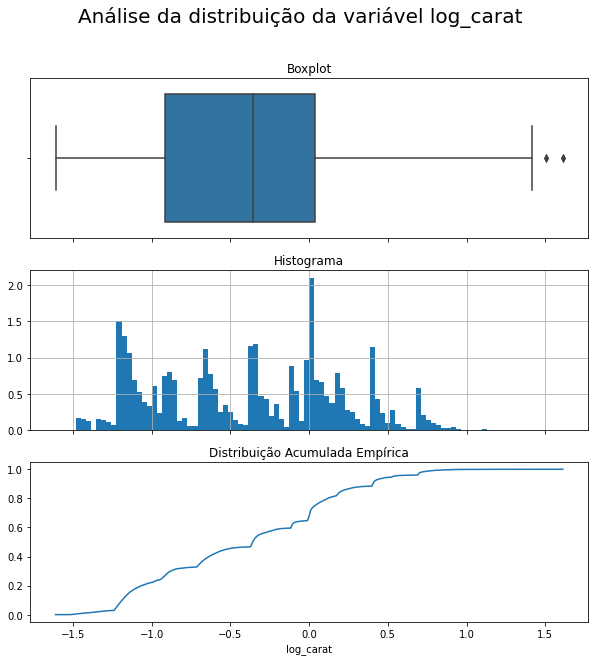

In [26]:
plot_distr(log_carat)

Segundo a literatura que estuda a distribuição do carat dos diamentes
(Sichel, 1973; Rombouts, 1995; Ferreira, 2013), em geral podemos representar
a distribuição de carats de diamentes através de um modelo de distribuição de
probabilidades log-normal. Porém, isso só é possível, como ressaltam Sichel
(1973) e Rombouts (1995) quando estamos lidando com uma amostra de dimantes
de mesma origem (de uma mesma mina). Caso contrário, teremos um modelo de
misturas de distribuições log-normais.

A partir da análise da distribuição, tanto dos dados em sua escala original
quanto em escala logarítimica, podemos inferir que a amostra deve ter sido
gerada por um modelo de misturas de log-normais. Ou seja, é como se amostras
de várias minas estivessem reunidas em nossa amostra de diamentes. Isso pode
ser averiguado uma vez que nossa amostra é multimodal, o que é um forte indício
de modelo de misturas uma vez que a distribuição log-normal é unimodal.

## Modelo de Mistura Log-Normal

Definido como ponto de partida trabalhar com a hipótese de modelos de misturas de 
distribuições log-normais, cabe agora especificar quantos modelos compõe a mistura.
Isso é equivalente a estipular de quantas populações específicas a nossa amostra
originou. Para tal serão testadas diversas quantidades de componentes. Analisando
visualmente o gráfico do histograma do logaritmo dos carats, é possível observar
uma quantidade aproximada de 7 modas. Supondo que cada moda esteja associada a uma
distribuição log-normal que compõe o modelo de mistura, é razoável que tenhamos
algo próximo de 7 modelos. Vamos optar por uma abordagem conversadora, serão testadas
valores entre 2 e 14 para a quantidade de componentes, totalizando assim 13 modelos.

Duas estatísticas serão utilizadas para avaliar cada um dos modelos: estatística de
teste de Kolmogorov-Smirnov e a divergência de Kullback-Leibler. O teste de
Kolmogorov-Smirnov mede se duas funções de de distribuição empírica vieram da função
de distribuição de probabilidade, ou se um função empírica originou de uma teórica
específica (Morettin e Bussabi, 2010). Sua estatística de teste é equivalente à maior
distancia entre duas funções de distribuição de probabilidade acumulada.
$$D=\max|F(x_i)-F_e(x_i)|$$

Já a divergência de Kullbvack-Leibler mede a divergência entre duas distribuições
(Bishop, 2006). Do ponto de vista da teoria da informação, divergência $KL{(p||q)}$
pode ser interpretada como a perda de informação quando utilizamos a distribuição
$q$ para representar a distribuição $p$. No nosso caso a distribuição $p$ seria a
empírica, enquanto a distribuição $q$ seria mistura de log-normais.
$$KL{(p||q)} = - \int{p(x)\ln(\frac{q(x)}{p(x)})}dx$$

In [37]:
def get_kl_divergence(model: GeneralMixtureModel,
                      x: pd.Series = carat,
                      seed: int = 27) -> np.array:
    """Calcula manualmente a divergência de KL
    
    O cálculo é realizado com base na série empírica e no modelo treinado
    Sendo o modelo utilizado para gerar os valores de probabilidade a partir
    dos valores únicos encontrados na série de dados empírica.
    """
    # definindo semente para controlar aleatoriedade
    if seed:
        np.random.seed(seed)
    # fonte: https://towardsdatascience.com/kl-divergence-python-example-b87069e4b810
    # distribuição de frequência dos valores da série
    x_pdf = x.value_counts(normalize=True).sort_index()
    # gerando os valores para a distância KL
    q = model.probability(x_pdf.index) / 100
    p = x_pdf.values
    
    return np.sum(np.where(q !=0, p * np.log(p/q), 0))

In [78]:
def fit_mixture_lognormal(n_components: int,
                          x: pd.Series = carat,
                          seed: int = 27) -> GeneralMixtureModel:
    """Treina um modelo de mistura lognormal com n_components"""
    # remodela os dados para um numpy coluna
    x_reshaped = x.values.reshape(x.shape[0], 1)
    if seed:
        np.random.seed(seed)
    # fit o modelo de mistura
    return GeneralMixtureModel.from_samples(LogNormalDistribution,
                                            n_components,
                                            x_reshaped)

In [81]:
def test_model(n_components: int,
               x: pd.Series = carat,
               ks_sample_size: int = 1000,
               seed: int = 27) -> tuple[float]:
    """Cria um modelo de mistura e testa sua aderência em relação aos dados"""
    # treina o modelo
    model = fit_mixture_lognormal(n_components)
    # obtém a divergência KL
    kl = get_kl_divergence(model)
    # aplica o teste KS para uma amostra dos dados
    if seed:
        np.random.seed(seed)
    ks_stats, ks_pvalue = stats.ks_2samp(x.sample(ks_sample_size).values,
                                         model.sample(ks_sample_size))
    return kl, ks_stats, ks_pvalue

In [82]:
def test_all_configurations(n_components_list: list[int],
                            x: pd.Series = carat,
                            seed: int = 27) -> pd.DataFrame:
    """Testa o modelo de mistura para cada n_component de uma lista"""
    # iniciando o dicionário onde serão armazenados os resultados
    result = dict(n_components=list(),
                  kl=list(),
                  ks_stats=list(),
                  ks_pvalue=list())
    
    # aplicando o teste para cada n_component da lista
    for n_components in n_components_list:
        # controlando a aleatoriedade
        if seed:
            np.random.seed(seed)
        kl, ks_stats, ks_pvalue = test_model(n_components)
        result["n_components"].append(n_components)
        result["kl"].append(kl)
        result["ks_stats"].append(ks_stats)
        result["ks_pvalue"].append(ks_pvalue)
            
    return pd.DataFrame(result).set_index("n_components")

In [83]:
mixture_test_results = test_all_configurations(range(2, 15))
mixture_test_results["ks_significant"] = mixture_test_results["ks_pvalue"] < .05
mixture_test_results

,kl,ks_stats,ks_pvalue,ks_significant
n_components,,,,
2,0.472431,0.061,0.048397,True
3,0.448292,0.064,0.033253,True
4,0.401501,0.064,0.033253,True
5,0.324733,0.064,0.033253,True
6,0.366592,0.072,0.011190,True
7,0.343953,0.066,0.025634,True
8,0.260497,0.053,0.120515,False
9,0.257624,0.054,0.108287,False
10,0.248041,0.054,0.108287,False


Pelo resultado dos experimentos, vemos que para todos os modelos com mais de 8 componentes,
não podemos rejeitar a hipótese nula de que os dados vem da mesma distribuição.
Esse resultado preliminar reforça nossa hipótese inicial de que os dados obtidos são oriundos de múltiplas fontes (populações), e dessa forma, o mais correto é representá-lo como um modelo de misturas de log-normais ao invés de uma distribuição log-normal.

Analisando agora a divergência KL, vemos que ela começa a estabilizar (reduz a velocidade de
redução) a partir de 8 componentes. Apesar de pelo teste KS todos os modelos de misturas com mais de quatro componentes log-normais serem boas aproximações da distribuição de carats, vamos analisar com maior profundidade os casos dos modelos que possuem entre 8 e 12 componentes.

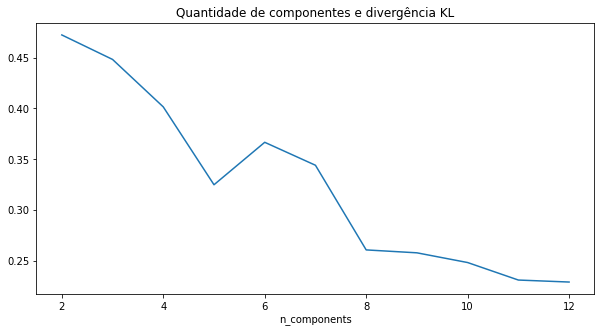

In [89]:
mixture_test_results["kl"].plot(figsize=(10, 5))
plt.title("Quantidade de componentes e divergência KL")
plt.show()

Essa análise se dará de forma gráfica, primeiro avaliando o quanto a pdf do modelo corresponde à distribuição dos dados (histograma) e em seguida o quanto a distribuição acumulada gerada pelos modelos estão alinhadas à empírica.

In [90]:
def plot_density(X_series, x, model, ax):
    ax.hist(X_series, density=True, bins=100)
    ax.plot(x, model.probability(x), label="density")

In [91]:
def plot_cdf(X_series, x, model, ax):
    prob = model.probability(x) / 100
    cumprob = prob.cumsum()
    
    X_series.value_counts(normalize=True).sort_index().cumsum().plot(ax=ax)
    ax.plot(x, cumprob)

In [92]:
def plot_models_graph_fit(n_components_list: list[int],
                          x: pd.Series = carat,
                          steps: float = 0.01,
                          figsize: tuple[int] = (15, 15),
                          seed: int = 27) -> None:
    
    s = np.arange(steps, x.max() + steps, steps)
    fig, axs = plt.subplots(len(n_components_list), 2, figsize=figsize, sharex=True)
    for n_components, row in zip(n_components_list, axs):
        np.random.seed(seed)
        model = fit_mixture_lognormal(n_components)
        plot_density(x, s, model, row[0])
        row[0].set_ylabel(f"{n_components} componentes")
        plot_cdf(x, s, model, row[1])
    fig.suptitle("Avaliação gráfica dos modelos de misturas log-normal", fontsize=20)
    plt.show()

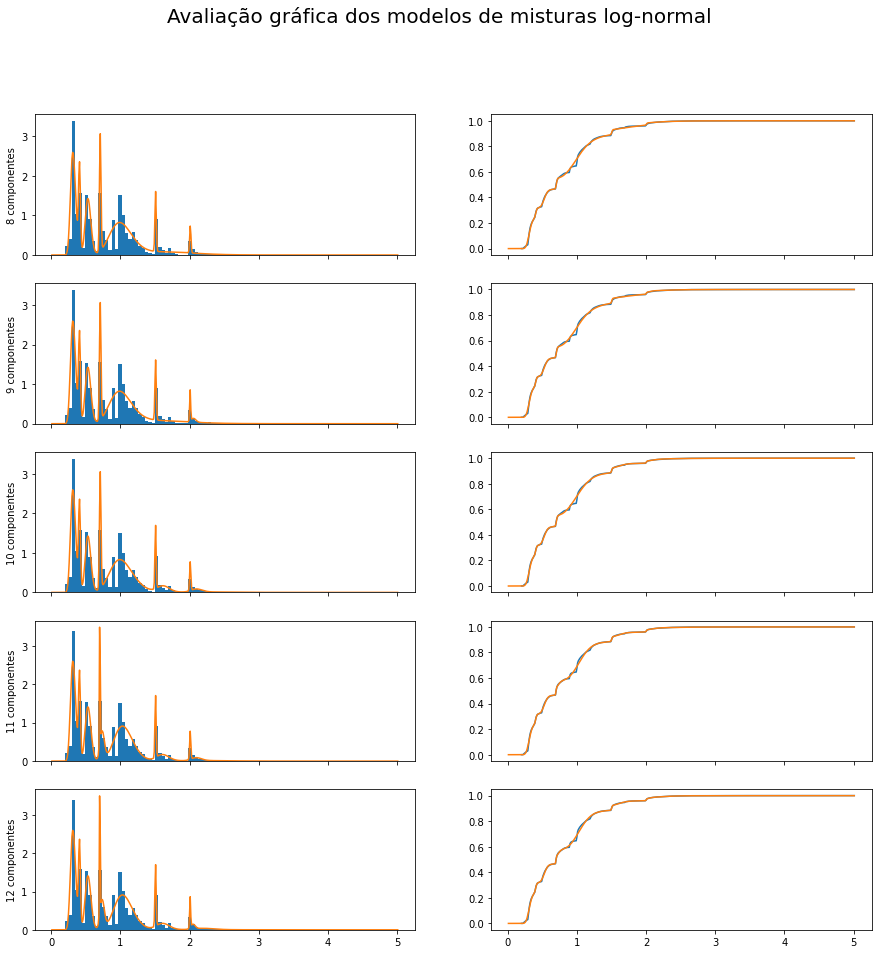

In [94]:
plot_models_graph_fit(range(8, 13))

Todos os modelos acima aparentam ter capacidades muito similares. Com isso, é muito provável que componentes adicionais além do 8 não aumentam a capacidade preditiva do modelo. Dessa forma, vamos escolher pelo mais simples e definir como um modelo de mistura de 8 log-normais como sendo aquele que mais se aproxima da distribuição de carats de nossa amostra de diamantes.

## Previsão da soma de carats da extração de 100 diamantes

Como mencionado no segundo item desse exercício, uma segunda etapa dessa análise é prever a distribuição do total de carats da extração de 100 diamantes. A nossa variável aleatória em questão é a soma de 100 amostras extraídas de uma variável aleatória de misturas de 8 log-normais. Dessa variável, vamos extrair 500 amostras e em seguida plotar o histograma.

In [96]:
np.random.seed(27)
model = fit_mixture_lognormal(8)
total_carat_sample = [np.sum(model.sample(100)) for _ in range(500)]

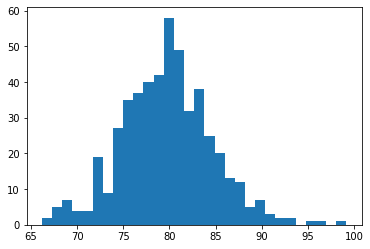

In [98]:
plt.hist(total_carat_sample, bins=30)
plt.show()

In [102]:
def ks_test(x: pd.Series,
            stats_name: str,
            stats_obj: stats.rv_continuous) -> tuple[float]:
    """"""
    params = stats_obj.fit(x)
    print(f"Média - {params[0]}")
    print(f"Desvio Padrão - {params[1]}")
    return stats.kstest(x, stats_name, params)

In [131]:
def plot_normal_graph_fit(x: np.array = total_carat_sample) -> None:
    """"""
    mu = np.mean(x)
    st = np.std(x)
    lower = np.min(x)
    upper = np.max(x)
    s = np.arange(lower, upper, 0.5)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True)

    ax1.hist(x, bins=30, density=True)
    ax1.plot(s, stats.norm.pdf(s, mu, st))
    ax1.set_title("Distribuição de Densidade da Normal")

    pd.Series(x).value_counts(normalize=True).sort_index().cumsum().plot(ax=ax2)
    ax2.plot(s, stats.norm.cdf(s, mu, st))
    ax2.set_title("Função de distribuição acumulada")
    fig.suptitle("Avaliação gráfica da distribuição normal", fontsize=20)
    plt.show()

In [103]:
ks_test(total_carat_sample, "norm", stats.norm)

Média - 79.73424093416797
Desvio Padrão - 4.941206750552241


KstestResult(statistic=0.0325648526409511, pvalue=0.6516527254360478)

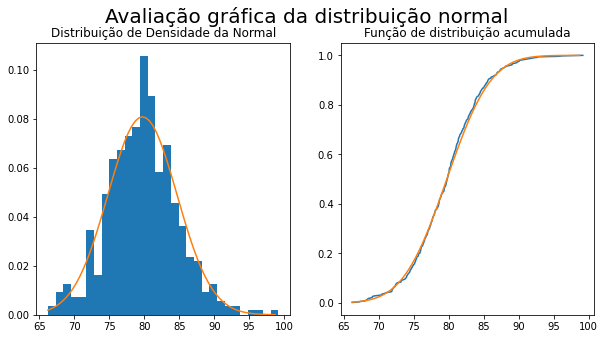

In [132]:
plot_normal_graph_fit()

Como era de se esperar, o teste KS não rejeita a hipótese nula ao nível de significância de 5%, e dessa forma não podemos rejeitar que a distribuição da soma de carats eja normal. Essa evidência é corroborada pela análise gráfica, onde tanto para os gráficos de densidade quanto de distribuição acumulada o modelo normal apresenta boa aderência em relação aos dados simulados a partir do modelo de misturas de 8 lognormais.

Esse fato já foi apontado por Ferreira (2013), onde o autor afirma que, segundo o Teorema do Limite Central, a soma de variáveis aleatórias de misturas de lognormais convergem assintoticamente para a distribuição normal.

## Referências

- BISHOP, C. M. Pattern recognition and machine learning. New York: Springer, 2006. 
- FERREIRA, J. Sampling and estimation of diamond content in kimberlite based microdiamonds. [s.l.] Ecole Nationale Supériere des Mines de Paris, 2013. 
- MORETTIN, P. A.; BUSSAB, W. DE O. Estatistica basica. São Paulo: Saraiva, 2010. 
- ROMBOUTS, L. Sampling and statistical evaluation of diamond deposits. Journal of Geochemical Exploration, p. 17, 1995. 
- SICHEL, H. S. Statistical valuation of diamondiferous deposits. JOURNAL OF THE SOUTH AFRICAN INSTITUTE OF MINING AND METALLURGY, p. 9, 1973. 
